## Домашнее задание

все материалы для выполения дз в `sem2.ipynb`


### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.




### Задание 2.

найти фичи с наибольшей значимостью, и вывести их

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt

In [2]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [3]:
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


In [4]:
df.shape

(226834, 2)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [6]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer

from nltk import ngrams
import nltk
from nltk import collocations 
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

from collections import Counter

In [7]:
nltk.download('genesis')
nltk.download('stopwords')
nltk.download('punkt')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package genesis to
[nltk_data]     /Users/aleksandrkrylov/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandrkrylov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aleksandrkrylov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
from string import punctuation
noise = stopwords.words('russian') + list(punctuation)

In [9]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [10]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

#### Задание 1

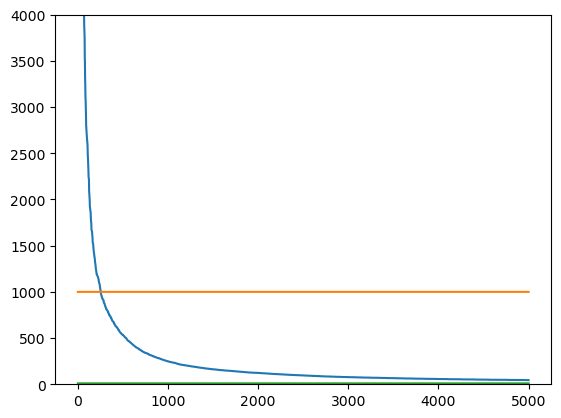

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
limit = 5000
first_100_freqs = [freq for word, freq in freq_dict_sorted[:limit]]
plt.plot(first_100_freqs)
plt.ylim(0, 4000)

#demostrate the thresholds
threshold_high = 1000
threshold_low = 10
plt.plot([i for i in range(1, limit+1)] , np.ones(limit)*threshold_high)
plt.plot([i for i in range(1, limit+1)] , np.ones(limit)*threshold_low)

plt.show()


In [12]:
# Создадим три группы токенов: с высокой, средней и низкой частотой

high_tokens = {token[0] for token in freq_dict_sorted if token[1] > threshold_high}
medium_tokens = {token[0] for token in freq_dict_sorted if threshold_low <= token[1] <= threshold_high}
low_tokens = {token[0] for token in freq_dict_sorted if token[1] < threshold_low}

print(len(high_tokens), len(medium_tokens), len(low_tokens))

255 19996 330872


In [13]:
frequences = np.array([token[1] for token in freq_dict_sorted])

In [14]:
# np.quantile(frequences, 0.01), np.quantile(frequences, 0.99)

from scipy import stats

stats.percentileofscore(frequences, 1, 'weak') / 100

0.6734135901094489

In [15]:
'''Addithional function for classification report recoerd'''
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['negative']['f1-score']
    f1_1 = report['positive']['f1-score']
    return f1_macro, f1_0, f1_1

In [16]:
def Create_Fit_Report (stop_words_list, name = 'None'):

    vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words_list)
    bow = vec.fit_transform(x_train)
    clf = LogisticRegression(solver='saga', random_state=42)
    clf.fit(bow, y_train)
    pred = clf.predict(vec.transform(x_test))

    print(classification_report(pred, y_test))

    report_test = classification_report(y_test, pred, output_dict=True)
    f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

    model_report = {
        f'f1_macro_test': f1_macro_test,
        f'f1_0_test': f1_0_test,
        f'f1_1_test': f1_1_test,
        f'train_tokens': name,
    }

    return model_report

In [17]:
stata = pd.DataFrame()

In [18]:
low_tokens_report = Create_Fit_Report(noise + list(high_tokens) + list(medium_tokens), name = 'low_tokens')

              precision    recall  f1-score   support

    negative       0.78      0.60      0.68     36566
    positive       0.49      0.70      0.58     20143

    accuracy                           0.63     56709
   macro avg       0.64      0.65      0.63     56709
weighted avg       0.68      0.63      0.64     56709



In [19]:

stata = stata.append(low_tokens_report, ignore_index=True)
stata

,f1_macro_test,f1_0_test,f1_1_test,train_tokens
0,0.627258,0.678329,0.576187,low_tokens


In [20]:
medium_tokens_report = Create_Fit_Report(noise + list(high_tokens) + list(low_tokens), name = 'medium_tokens')

              precision    recall  f1-score   support

    negative       0.77      0.72      0.75     29873
    positive       0.71      0.76      0.74     26836

    accuracy                           0.74     56709
   macro avg       0.74      0.74      0.74     56709
weighted avg       0.74      0.74      0.74     56709



In [21]:
stata = stata.append(medium_tokens_report, ignore_index=True)
stata

,f1_macro_test,f1_0_test,f1_1_test,train_tokens
0,0.627258,0.678329,0.576187,low_tokens
1,0.741817,0.746721,0.736914,medium_tokens


In [22]:
high_tokens_report = Create_Fit_Report(noise + list(medium_tokens) + list(low_tokens), name = 'high_tokens')

              precision    recall  f1-score   support

    negative       0.72      0.62      0.66     32646
    positive       0.56      0.67      0.61     24063

    accuracy                           0.64     56709
   macro avg       0.64      0.65      0.64     56709
weighted avg       0.65      0.64      0.64     56709



In [23]:
stata = stata.append(high_tokens_report, ignore_index=True)
stata

,f1_macro_test,f1_0_test,f1_1_test,train_tokens
0,0.627258,0.678329,0.576187,low_tokens
1,0.741817,0.746721,0.736914,medium_tokens
2,0.639010,0.663518,0.614503,high_tokens


In [24]:
print(len(low_tokens), len(medium_tokens), len(high_tokens))

330872 19996 255


Для получения адекватных значений метрик необходимо понять где ставить отсечки (ниже показаны результаты менее удачного примера разбиения) чтобы в выборке было достаточно токенов.

При использовании осечек по частотам 1000 и 10 для выско и низкочастотных токенов получаем что лучшее качество достигается при использовании среднечастотных токенов как несущих основную смысловаую нагрузку

In [ ]:
"""
#  результат при использовании отсечения по частоте 8000 - 500 


threshold_high = 8000
threshold_low = 500

# print(len(low_tokens),len(medium_tokens),len(high_tokens))  
# 350587 502  34 

# итоговые результаты

f1_macro_test	f1_0_test	f1_1_test	train_tokens
0	0.746333	0.754841	0.737825	low_tokens
1	0.647895	0.609169	0.686620	medium_tokens
2	0.577405	0.664884	0.489927	high_tokens 
'''
"""

"\n#  результат при использовании отсечения по частоте 8000 - 500 \n\n\nthreshold_high = 8000\nthreshold_low = 500\n\n# print(len(low_tokens),len(medium_tokens),len(high_tokens))  \n# 350587 502  34 \n\n# итоговые результаты\n\nf1_macro_test\tf1_0_test\tf1_1_test\ttrain_tokens\n0\t0.746333\t0.754841\t0.737825\tlow_tokens\n1\t0.647895\t0.609169\t0.686620\tmedium_tokens\n2\t0.577405\t0.664884\t0.489927\thigh_tokens \n'''\n"

### Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27866
    positive       1.00      1.00      1.00     28843

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



In [29]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [31]:
feature_importances = clf.coef_[0]
feature_names = vec.get_feature_names()

df_importance = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
df_importance = df_importance.sort_values('importance', ascending=False)
df_importance['feature'][:30].tolist()

[')',
 'd',
 'dd',
 '^_^',
 'ddd',
 '-d',
 '*',
 ':',
 'dddd',
 'ddddd',
 'люблю',
 'dddddd',
 'спасибо',
 '=^_^=',
 'х',
 '%',
 'рождения',
 'ахахах',
 'okirilyuk',
 'приятно',
 'ахах',
 'ddddddd',
 'тебе',
 ',',
 'dddddddd',
 'ты',
 'всем',
 'dtoropova',
 'вас',
 'спокойной']

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [36]:
# Create and evaluate CountVectorizer model

vec = CountVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(solver='saga', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))

print(classification_report(pred, y_test))

# report_test = classification_report(y_test, pred, output_dict=True)
# f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

# model_report = {
#     f'f1_macro_test': f1_macro_test,
#     f'f1_0_test': f1_0_test,
#     f'f1_1_test': f1_1_test,
#     f'train_tokens': name,
# }


              precision    recall  f1-score   support

    negative       0.77      0.78      0.77     27611
    positive       0.78      0.78      0.78     29098

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [35]:
# Create and evaluate TfidfVectorizer model

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1, 2))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.75      0.77      0.76     27265
    positive       0.78      0.76      0.77     29444

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [37]:
# Create and evaluate HashingVectorizer model

from sklearn.feature_extraction.text import HashingVectorizer

vec = HashingVectorizer(n_features=4)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.40      0.51      0.45     21952
    positive       0.63      0.52      0.57     34757

    accuracy                           0.52     56709
   macro avg       0.52      0.52      0.51     56709
weighted avg       0.54      0.52      0.53     56709



#### Подобрать оптимальный размер для hashing векторайзера

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [63]:
n_features = range(50, 550, 50)

In [47]:
pipeline = Pipeline(steps=[('vec', HashingVectorizer()),
                           ('clf', LogisticRegression())])

In [48]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vec', 'clf', 'vec__alternate_sign', 'vec__analyzer', 'vec__binary', 'vec__decode_error', 'vec__dtype', 'vec__encoding', 'vec__input', 'vec__lowercase', 'vec__n_features', 'vec__ngram_range', 'vec__norm', 'vec__preprocessor', 'vec__stop_words', 'vec__strip_accents', 'vec__token_pattern', 'vec__tokenizer', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [64]:
parameters = dict(vec__n_features=n_features)

In [65]:
gs = GridSearchCV(pipeline, parameters)
gs.fit(df.text, df.label)

GridSearchCV(estimator=Pipeline(steps=[('vec', HashingVectorizer()),
                                       ('clf', LogisticRegression())]),
             param_grid={'vec__n_features': range(50, 550, 50)})

In [66]:
print('Best number of features:', gs.best_estimator_.get_params()['vec__n_features'])

Best number of features: 450


In [67]:
gs.best_score_

0.6291737711988693

In [62]:
# HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

vec = HashingVectorizer(n_features=185)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.60      0.61      0.60     27404
    positive       0.63      0.62      0.62     29305

    accuracy                           0.61     56709
   macro avg       0.61      0.61      0.61     56709
weighted avg       0.61      0.61      0.61     56709



C помощью GridSearchCV удалось выявить оптимальный размер hashing векторайзера = 450, но в целом видно что чем больше фичей тем выше результат

#### Neural Networks

In [69]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [94]:
# labelEncode целевую переменную

from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [105]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_data = train_data.batch(256)
valid_data = valid_data.batch(256)

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

In [106]:
seq_lengths = [len(x) for x in x_train.values]

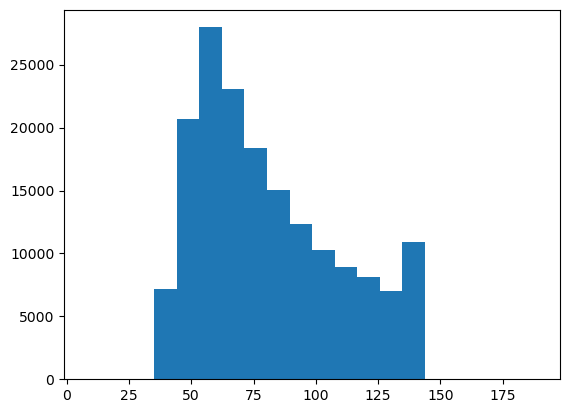

In [107]:
plt.hist(seq_lengths, bins=20);

In [108]:
def custom_standardization(input_data):
    
    return input_data

vocab_size = 10000
seq_len = 130

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [109]:
embedding_dim=200

In [113]:
class myNet_Conv(tf.keras.Model):
    def __init__(self):
        super(myNet_Conv, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim, name="embedding")
        self.conv1 = Conv1D(200, (3))
        self.conv2 = Conv1D(200, (3))
        self.gPool = GlobalAveragePooling1D()
        self.fc1 = Dense(100, activation='relu')
        self.fc2 = Dense(1)


    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x1 = self.conv1(x)
        x = self.conv2(x)
        x = self.gPool((x + x1)/2)
        x = self.fc1(x)
        return self.fc2(x)

In [117]:
model_conv = myNet_Conv()

In [118]:
model_conv.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [119]:
model_conv_history = model_conv.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
665/665 [==============================] - 159s 238ms/step - loss: 0.4436 - accuracy: 0.7368 - val_loss: 0.3656 - val_accuracy: 0.8200
Epoch 2/10
665/665 [==============================] - 155s 233ms/step - loss: 0.3369 - accuracy: 0.8144 - val_loss: 0.3484 - val_accuracy: 0.8084
Epoch 3/10
665/665 [==============================] - 157s 236ms/step - loss: 0.3233 - accuracy: 0.8223 - val_loss: 0.3506 - val_accuracy: 0.7979
Epoch 4/10
665/665 [==============================] - 157s 237ms/step - loss: 0.3150 - accuracy: 0.8282 - val_loss: 0.3509 - val_accuracy: 0.7947
Epoch 5/10
665/665 [==============================] - 158s 238ms/step - loss: 0.3050 - accuracy: 0.8351 - val_loss: 0.3508 - val_accuracy: 0.8012
Epoch 6/10
665/665 [==============================] - 159s 240ms/step - loss: 0.2967 - accuracy: 0.8410 - val_loss: 0.3554 - val_accuracy: 0.8017
Epoch 7/10
665/665 [==============================] - 161s 241ms/step - loss: 0.2863 - accuracy: 0.8473 - val_loss: 0.3613 -

#### NN # 2

In [185]:
class myNet_GRU(tf.keras.Model):
    def __init__(self):
        super(myNet_GRU, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim, input_length=seq_len,  name="embedding")
        self.conv1 = Conv1D(100, (3), padding='same')
        self.conv2 = Conv1D(100, (2), padding='same')
        self.gru = GRU(200, return_sequences=True)
        self.gpool = GlobalAveragePooling1D()
        self.fc1 = Dense(100, activation='relu')
        self.fc2 = Dense(1)


    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.gru(x)
        x = self.gpool(x)
        x = self.fc1(x)
        return self.fc2(x)

In [186]:
model_gru_1 = myNet_GRU()

In [187]:
model_gru_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [188]:
model_gru_history = model_gru_1.fit(train_data, validation_data=valid_data, epochs=5)

Epoch 1/5
665/665 [==============================] - 289s 432ms/step - loss: 0.4197 - accuracy: 0.7577 - val_loss: 0.3369 - val_accuracy: 0.8066
Epoch 2/5
665/665 [==============================] - 302s 454ms/step - loss: 0.3137 - accuracy: 0.8295 - val_loss: 0.3484 - val_accuracy: 0.8031
Epoch 3/5
665/665 [==============================] - 298s 448ms/step - loss: 0.2839 - accuracy: 0.8491 - val_loss: 0.4043 - val_accuracy: 0.7957
Epoch 4/5
665/665 [==============================] - 306s 461ms/step - loss: 0.2428 - accuracy: 0.8770 - val_loss: 0.5151 - val_accuracy: 0.7881
Epoch 5/5
665/665 [==============================] - 309s 465ms/step - loss: 0.2079 - accuracy: 0.8975 - val_loss: 0.5488 - val_accuracy: 0.8013


#### Выводы

count векторайзер показал похожие результаты с tf-idf векторайзером

hashing векторайзер показал более слабые метрики по сравнению с count  и tf-idf

Были построены 2 нейронные сетки - показали довольно неплохие результаты, однако наблюдается переобучение (метрика растет на тренировочном датасете и стоит на месте на валидационном)